# Ten Years Stroke project

This project aims to construct a Bayesian Network model to analyze and quantify the primary risk factors relevant to heart disease prevention.

In [392]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork

from pgmpy.estimators.CITests import chi_square
from sklearn.metrics import classification_report,f1_score
from pgmpy.inference import VariableElimination

In [275]:
# Load the data
dataframe = pd.read_csv('tenyear_stroke.csv')
dataframe.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


# 1. Data Exploration

In [276]:
# Divide continuous and discrete and filter out undesired variables
dataframe = dataframe[dataframe['BPMeds']==0]
continuous_data = dataframe[['age','totChol','sysBP','diaBP','BMI','cigsPerDay']]
discrete_data = dataframe[['male','prevalentStroke','diabetes','TenYearCHD']]

data = dataframe[['age','totChol','sysBP','diaBP','BMI','cigsPerDay','male','prevalentStroke','diabetes','TenYearCHD']]

### Correlation

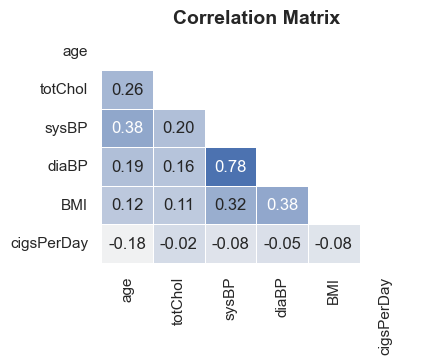

In [277]:
# Correlation matrix
corr_matrix = continuous_data.corr()

plt.figure(figsize=(4, 3))  
sns.set(style="white")
cmap=sns.color_palette("light:b", as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool),k=0)

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap=cmap,
    fmt='.2f',
    linewidths=0.5,
    cbar=False
)

plt.title("Correlation Matrix", fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()


### Outliers

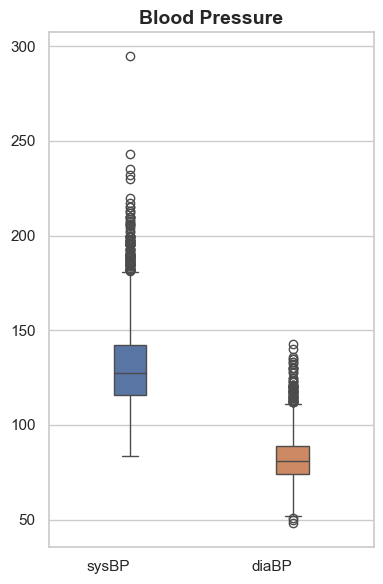

In [278]:
data_pr = continuous_data[['sysBP','diaBP']]

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named `df`
plt.figure(figsize=(4, 6))
sns.set(style="whitegrid")

sns.boxplot(data=data_pr,width=0.2)  # By default, boxplots are vertical

plt.title("Blood Pressure", fontsize=14, fontweight='bold')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

### Frequency histograms

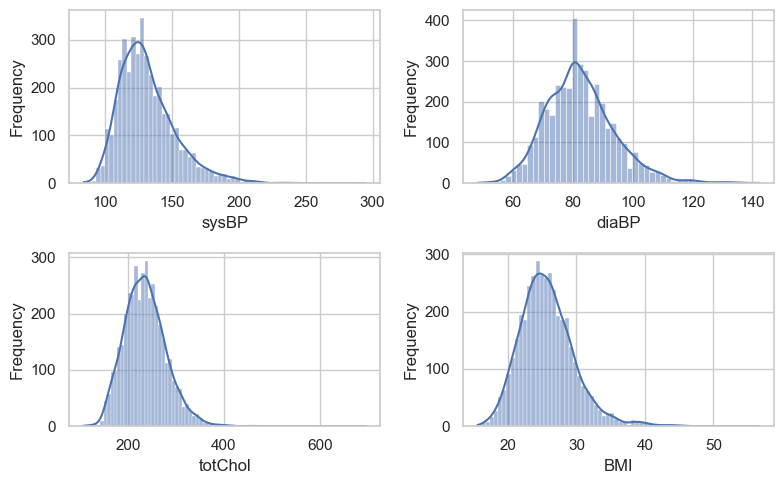

In [279]:
data_hist = continuous_data[['totChol','sysBP','diaBP','BMI']]
fig, axes = plt.subplots(2, 2, figsize=(8, 5))
features = ['sysBP','diaBP','totChol','BMI']

axes = axes.flatten()

custom_bins = [-1, 100, 400]

# Plot a histogram for each feature
for i, feature in enumerate(features):
    sns.histplot(data_hist[feature], kde=True, ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### Metrics

In [280]:
from skimpy import skim 

skim(continuous_data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 4061   │ │ float64     │ 5     │                                                          │
│ │ Number of columns │ 6      │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column      ┃ NA  ┃ NA %                ┃ mean   ┃ sd     ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ age         │   0 │                   0 │  49.35 │  8.511 │    32 │    42 │    48 │    56 │    70 │ ▃█▇▇▅▂ │  │
│ │ totChol     │  46 │  1.1327259295739966 │  236.1 │  44.23 │   107 │   205 │   233 │   262 │   696 │  ▃█▁   │  │
│ │ sysBP       │   0 │                   0 │  131.3 │   21.1 │  83.5 │   116 │ 127.5 │   142 │   295 │  ▄█▂   │  │
│ │ diaBP       │   0 │                   0 │  82.48 │  11.62 │    48 │    74 │    81 │    89 │ 142.5 │  ▁▆█▂  │  │
│ │ BMI         │  18 │  0.4432405811376508 │  25.73 │   4.02 │ 15.54 │ 23.06 │ 25.36 │ 27.96 │  56.8 │  ▂█▂   │  │
│ │ cigsPerDay  │  29 │  0.7141098251662152 │   9.11 │  11.96 │     0 │     0 │     0 │    20 │    70 │  █▃▁   │  │
│ └─────────────┴─────┴─────────────────────┴────────┴────────┴───────┴───────┴───────┴───────┴───────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

# 2. Data Engeneering

Transform continuous data to discrete using medical information.

In [281]:
# Function does not accept missing values
data_cl = data.dropna()

In [282]:
# Age
data_cl = data_cl[(data_cl['age'] >= 30) & (data_cl['age'] <= 75)]
data_cl['age'] = pd.cut(data_cl.age,bins=[29,44,54,64,75],labels=['30-44','45-54','55-64','65-75'],ordered=True).astype(str)

# Cholesterol-level
data_cl = data_cl[(data_cl['totChol'] >= 100) & (data_cl['totChol'] <= 500)]
data_cl['totChol'] = pd.cut(data_cl.totChol,bins=[99,199,239,500],labels=['Optimal','Elevated','High'],ordered=True).astype(str)

# Body Mass Index 
data_cl = data_cl[(data_cl['BMI'] <= 50)]
data_cl['BMI'] = pd.cut(data_cl.BMI,bins=[14.,18.4,24.9,29.9,50],labels=['Underweight','Normal','Overweight','Obese'],ordered=True).astype(str)

#Cigs Per Day 
data_cl = data_cl[(data_cl['cigsPerDay'] <= 50)]
data_cl['cigsPerDay'] = pd.cut(data_cl.cigsPerDay,bins=[-1,0,5,19,50],labels=['NonSmoker','LightSmoker','ModerateSmoker','SevereSmoker'],ordered=True).astype(str)

# Glucose levels
#data_cl = data_cl[(data_cl['glucose'] <= 250)]
#data_cl['glucose'] = pd.cut(data_cl.glucose,bins=[0,116,136,250],labels=[0,1,2],ordered=True).astype(int)

In [283]:
# Create a Blood pressure variable

bloodP= []

# Systolic-Pressure
data_cl = data_cl[(data_cl['sysBP'] >= 40) & (data_cl['sysBP'] <= 250)]
# Diastolic-Pressure
data_cl = data_cl[(data_cl['diaBP'] >= 40) &(data_cl['diaBP'] <= 140)]

for i,sys in enumerate(data_cl.sysBP.values):
    dia = data_cl.diaBP.values[i]

    if (sys<=120 and dia<=80):
        blood = 'Optimal'
    elif (sys<=140 and dia<=90):
        blood = 'Elevated'
    else: 
        blood = 'Hypertension'
    bloodP.append(blood)
    
data_cl['BP'] = bloodP

In [284]:
# Rename features and adjust the final dataset

data_cl.columns=['Age','TotC','SBP','DBP','BMI','CxD','GEN','PStroke','DB','TYS','BP']
data_cl = data_cl[['Age','TotC','SBP','DBP','BMI','CxD','GEN','PStroke','DB','BP','TYS']]


data_cl['GEN'] = data_cl['GEN'].map({1:'Male',0:'Female'})
data_cl['DB'] = data_cl['DB'].map({1:'Diabetic',0:'Healthy'})
data_cl['PStroke'] = data_cl['PStroke'].map({1:'Had Stroke',0:'No Stroke'})
data_cl['TYS'] = data_cl['TYS'].map({1:'At-Risk',0:'Healthy'})

dataset = data_cl.drop(['SBP','DBP'],axis=1)
dataset = dataset.astype('str')

dataset.head()

,Age,TotC,BMI,CxD,GEN,PStroke,DB,BP,TYS
0,30-44,Optimal,Overweight,NonSmoker,Male,No Stroke,Healthy,Optimal,Healthy
1,45-54,High,Overweight,NonSmoker,Female,No Stroke,Healthy,Elevated,Healthy
2,45-54,High,Overweight,SevereSmoker,Male,No Stroke,Healthy,Elevated,Healthy
3,55-64,Elevated,Overweight,SevereSmoker,Female,No Stroke,Healthy,Hypertension,At-Risk
4,45-54,High,Normal,SevereSmoker,Female,No Stroke,Healthy,Elevated,Healthy


In [285]:
profile = ProfileReport(dataset, title="Data Summary", minimal=True)
profile.to_notebook_iframe()  # or profile.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 1292.01it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 3. Definition of Bayesian Network

## a. Hill search

In [286]:
# Set some boundaries
fixeed_edges = [('Age','BP'),('GEN','BP'),('CxD','BP'),('BP','TYS')]
forbidden_edges = [(node,'Age') for node in dataset.columns] + \
                  [(node,'GEN') for node in dataset.columns] + \
                   [(node,'CxD') for node in dataset.columns]

# Define the method
score = HillClimbSearch(dataset)

best_model = score.estimate(scoring_method=BicScore(dataset),max_indegree=5,
                            fixed_edges=fixeed_edges,black_list=forbidden_edges)

# Construct the network
hill_model=BayesianNetwork(best_model.edges())
hill_model.fit(dataset, estimator=MaximumLikelihoodEstimator)
hill_model.check_model()


  0%|          | 0/1000000 [00:00<?, ?it/s]

True

## b. Personal definition

In [353]:
# Run test on independence 
print(chi_square(X='Age',Y='GEN', Z=[] ,data=dataset, significance_level = 0.05))

True


In [354]:
cust_edges = [  ('Age','PStroke'),('Age','BMI'),('Age','TotC'),
                ('GEN','BMI'),('GEN','TotC'),       # Set the dependency of gender and age
                
                ('CxD','DB'),('BMI','DB'), # Set diabetes
                ('CxD','BP'),('PStroke','BP'),('BMI','BP'),('TotC','BP'),('DB','BP'), # Set blood pressure
                
                ('BP','TYS'),('DB','TYS')] 

cust_model= BayesianNetwork(cust_edges)
cust_model.fit(dataset, estimator=MaximumLikelihoodEstimator)
cust_model.check_model()

True

### Compare the two models using Bayesian Information Criteria

In [289]:
bic = BicScore(dataset)

print(f'Model_hill BIC: {bic.score(hill_model)}')
print(f'Custom model BIC: {bic.score(cust_model)}')

Model_hill BIC: -26442.130498751903
Custom model BIC: -27933.37994647852


### Give a better look at the custom model

# 4. Variable elimination and predictive capabilities

## a. Variable Elimination 

In [352]:
infer = VariableElimination(cust_model)

glu_infer = infer.query(variables=['TYS'], evidence={'Age':'65-75'})
print(glu_infer)

+--------------+------------+
| TYS          |   phi(TYS) |
+==============+============+
| TYS(At-Risk) |     0.1496 |
+--------------+------------+
| TYS(Healthy) |     0.8504 |
+--------------+------------+


In [291]:
# Query 1: Age = 30-44
res_30_44 = infer.query(variables=['BMI'], evidence={'Age': '30-44'})

# Query 2: Age = 45-54
res_45_54 = infer.query(variables=['BMI'], evidence={'Age': '45-54'})

# Ottieni le distribuzioni
dist_30_44 = dict(zip(res_30_44.state_names['BMI'], res_30_44.values))
dist_45_54 = dict(zip(res_45_54.state_names['BMI'], res_45_54.values))

# Crea DataFrame
df = pd.DataFrame({
    'BMI': list(dist_30_44.keys()),
    'P(BMI | Age=30-44)': list(dist_30_44.values()),
    'P(BMI | Age=45-54)': [dist_45_54[bmi] for bmi in dist_30_44.keys()]
})

print(df)

           BMI  P(BMI | Age=30-44)  P(BMI | Age=45-54)
0       Normal            0.515080            0.437390
1        Obese            0.108098            0.123784
2   Overweight            0.359695            0.426773
3  Underweight            0.017128            0.012053


## b. Predictions

In [326]:
# DIVIDE IN TRAIN AND TEST
from imblearn.over_sampling import SMOTEN

X = dataset.drop(['TYS'],axis=1)
y = dataset[['TYS']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_train, y_train, test_size=0.3)
# Initialize SMOTENC
smoten = SMOTEN(sampling_strategy=0.3)

# Apply SMOTE
X_train, y_train = smoten.fit_resample(X_train, y_train)

train_net = pd.concat([X_train,y_train],axis=1)
val_net = pd.concat([X_val,y_val],axis=1)
test_net =  pd.concat([X_test,y_test],axis=1)

In [327]:
# Fit the network on train data

inf_model= BayesianNetwork(cust_edges)
inf_model.fit(train_net, estimator=MaximumLikelihoodEstimator)
inf_model.check_model()

True

In [378]:
true_values = []
predicted_probs = []

inference = VariableElimination(cust_model)
keys_to_keep = [node for node in cust_model.nodes()]


# Iterate over each row in the test set (assuming 'test_net' is your test data)
for index, row in dataset.iterrows():
    
    evidence = row.to_dict()
    evidence = {k: v for k, v in evidence.items() if k in keys_to_keep}
    del evidence['TYS']
    
    # Use the trained Bayesian network model to predict the probability distribution of 'Y'
    prediction = inference.query(variables=['TYS'], evidence=evidence)
  
    predicted_prob=prediction.values[0]
            
    # True value of 'Y' from the test set
    true_y = row['TYS']
    
    # Append true and predicted values
    true_values.append(true_y)
    predicted_probs.append(predicted_prob)

In [411]:
# Initialize variables to track best threshold and its corresponding f1 score
best_threshold = 0
best_f1_weighted = 0

# Range of thresholds to test
thresholds = np.linspace(0, 1, 100)

# Store F1 scores for plotting
f1_scores = []

# Loop over thresholds to find the best one
for threshold in thresholds:
    # Classify labels based on the threshold
    predicted_values = ['At-Risk' if pred >= threshold else 'Healthy' for pred in predicted_probs]
    
    # Compute weighted F1 score
    f1_weighted = f1_score(true_values,predicted_values,pos_label='At-Risk')
    f1_scores.append(f1_weighted)
    
    # Update best threshold if this F1 score is better
    if f1_weighted > best_f1_weighted:
        best_f1_weighted = f1_weighted
        best_threshold = threshold

# Print the best threshold and corresponding weighted F1 score
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1_weighted:.4f}")


Best Threshold: 0.12
Best F1 Score: 0.2947


### Evaluate on test set

In [408]:
from pgmpy.inference import VariableElimination

true_values = []
predicted_probs = []

inference = VariableElimination(cust_model)
keys_to_keep = [node for node in cust_model.nodes()]


# Iterate over each row in the test set (assuming 'test_net' is your test data)
for index, row in test_net.iterrows():
    
    evidence = row.to_dict()
    evidence = {k: v for k, v in evidence.items() if k in keys_to_keep}
    del evidence['TYS']

    remove_list = []
    for var in cust_model.nodes():
        if var not in evidence.keys():
            remove_list.append
    
    # Use the trained Bayesian network model to predict the probability distribution of 'Y'
    prediction = inference.query(variables=['TYS'], evidence=evidence)
    
    predicted_prob=prediction.values[0]
            
    # True value of 'Y' from the test set
    true_y = row['TYS']
    
    # Append true and predicted values
    true_values.append(true_y)
    predicted_probs.append(predicted_prob)

In [410]:
predicted_values = ['At-Risk' if pred >= best_threshold else 'Healthy' for pred in predicted_probs]
report= classification_report(true_values,predicted_values,labels=['Healthy','At-Risk'],zero_division=False)

print(report)

              precision    recall  f1-score   support

     Healthy       0.91      0.70      0.79       725
     At-Risk       0.20      0.53      0.29       105

    accuracy                           0.68       830
   macro avg       0.56      0.62      0.54       830
weighted avg       0.82      0.68      0.73       830

